In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [ ]:
print("="*50)
print("LOADING DATA")
print("="*50)

#  Load your CSV file
df = pd.read_csv("/content/YoutubeCommentsDataSet.csv")

print("The Dataset consists of: ")
df.head(5)



LOADING DATA
The Dataset consists of: 


,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [ ]:
df.isnull().sum()

,0
Comment,44
Sentiment,0
num_stop_words,0


In [ ]:
# df.info()

df.describe()

,Comment,Sentiment
count,18364,18408
unique,17871,3
top,nice,positive
freq,10,11432


In [ ]:
df.shape

(18408, 2)

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.shape

(17877, 2)

In [ ]:
df[(df['Comment'].str.strip() == '')]

,Comment,Sentiment


In [ ]:
# Convert the 'Comment' column to string type first to handle potential float (NaN) values.
# This will prevent the AttributeError when applying string methods like endswith() or startswith().
temp_comment_series = df['Comment'].astype(str)

# Now, filter the DataFrame to find comments that have leading or trailing spaces.
# This check is performed on the string representation of the comments.
df[temp_comment_series.apply(lambda x: x.endswith(' ') or x.startswith(' '))]

,Comment,Sentiment
20,linus just turn the key lights 180 and bounce ...,positive
30,unstoppable experiments with liquid nitrogen,positive
35,കേരളത്തിൽ ആദ്യമായി പെട്രോളിനെ എയ്സ് ആക്കിയ m4...,neutral
38,തന്നെ തളർത്താൻ നോക്കിയവർ പോലും അവന്റെ ഉയർച്ചയി...,neutral
39,എത്ര എടുത്താലും തീരാത്ത liquid nitrogen,neutral
...,...,...
18250,wow congratulations for starting such an amazi...,positive
18278,omg such awesome day to day life examples give...,positive
18343,amazing explanation i loved the way you taught,positive
18349,idk if you realise the intensity of positive i...,positive


**Pre-proccessing of the data**

In [ ]:
# Replace \n with space in between.

# Convert to string first to handle potential NaN values gracefully
df['Comment'] = df['Comment'].astype(str).str.replace('\n', ' ')

# Verify the transformation by checking for any remaining new lines
# Convert to string again for robustness before checking for newlines
comments_with_newline = df[df['Comment'].astype(str).str.contains('\n')]
comments_with_newline.head()

,Comment,Sentiment


**Exploratory Data Analysis**

<Axes: xlabel='Sentiment', ylabel='count'>

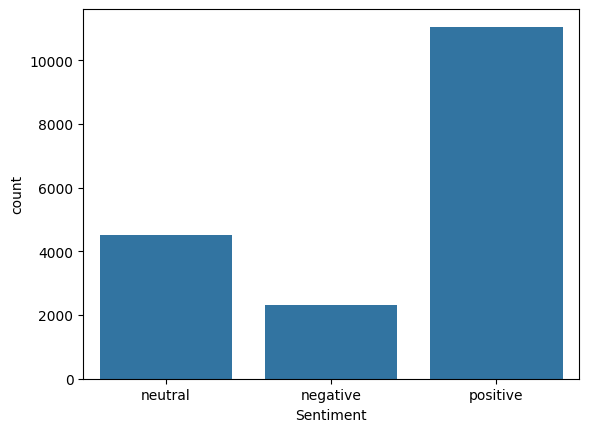

In [ ]:
sns.countplot(data=df, x="Sentiment")

In [ ]:
df['Sentiment'].value_counts()

,count
Sentiment,
positive,11055
neutral,4504
negative,2318


In [ ]:
df['Sentiment'].value_counts(normalize=True)*100

# normalize=True --> gives the decimal value or ratio whereas
# normalize=False --> gives the numerical/total count value

,proportion
Sentiment,
positive,61.839235
neutral,25.194384
negative,12.966381


In [ ]:
df['word_count'] = df['Comment'].apply(lambda x: len(x.split()))

In [ ]:
df.sample(10)

,Comment,Sentiment,word_count
10051,hes too funny great introduction to african am...,positive,12
2920,love your teaching style i learn so much you m...,positive,14
16063,จกป็อปคอร์นรอ,positive,1
8180,love the sonicthemed asmr videos hoping we get...,positive,14
12440,here im watching this youtube video when i sho...,neutral,78
3081,can we appreciate everything they do and let’s...,positive,26
11665,deus te abençoe sempre caduxin e feuripe cadeira,neutral,8
17098,00000 introduction to the course and outline ...,neutral,118
9124,you can literally buy almost everything in ind...,positive,18
5532,besides ai i’m more impressed with this man’s ...,positive,14


In [ ]:
# Define the mapping for sentiments
sentiment_mapping = {
    'positive': 1,
    'negative': -1,
    'neutral': 0
}

# Apply the mapping to the 'Sentiment' column
df['SN'] = df['Sentiment'].map(sentiment_mapping)

# Display the first few rows with the new column
display(df[['Comment', 'Sentiment', 'SN']].head())

,Comment,Sentiment,SN
0,lets not forget that apple pay in 2014 require...,neutral,0
1,here in nz 50 of retailers don’t even have con...,negative,-1
2,i will forever acknowledge this channel with t...,positive,1
3,whenever i go to a place that doesn’t take app...,negative,-1
4,apple pay is so convenient secure and easy to ...,positive,1


<Axes: xlabel='SN', ylabel='count'>

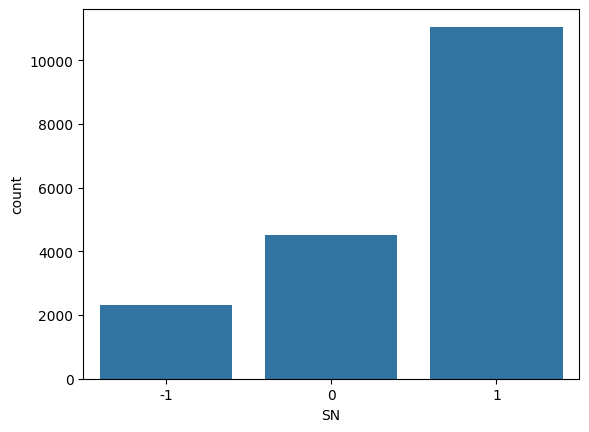

In [ ]:
sns.countplot(data=df, x="SN")

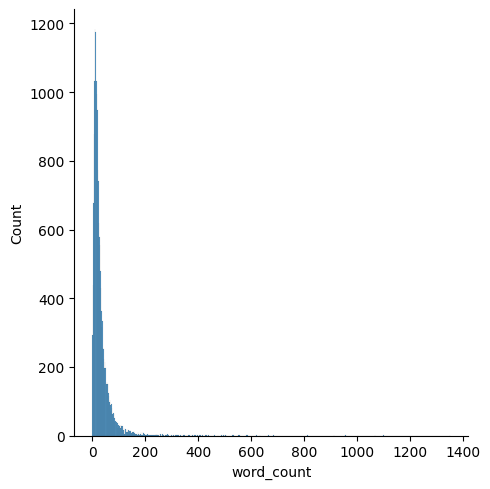

In [ ]:
sns.displot(data=df, x="word_count")

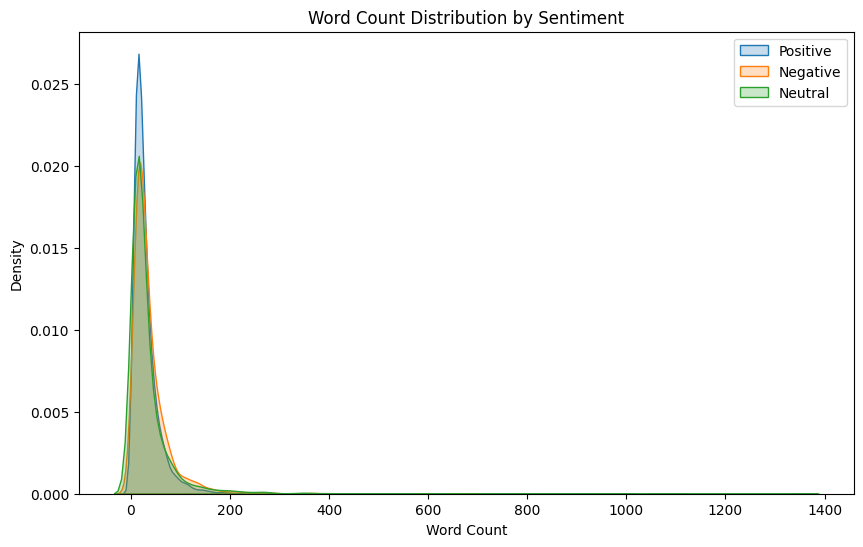

In [ ]:
# Create the figure and axes
plt.figure(figsize=(10,6))

sns.kdeplot(df[df['SN'] == 1]['word_count'], label='Positive', fill=True)
sns.kdeplot(df[df['SN'] == -1]['word_count'], label='Negative', fill=True)
sns.kdeplot(df[df['SN'] == 0]['word_count'], label='Neutral', fill=True)

plt.title('Word Count Distribution by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.legend()
plt.show()


# Main objective is to compare the length of the sample text(word count) as per different sentiment category

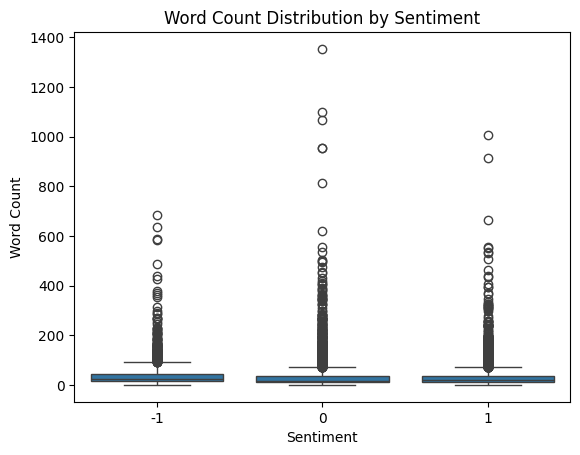

In [ ]:
sns.boxplot(data=df, x="SN", y="word_count")
plt.title('Word Count Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Word Count')
plt.show()

**Natural Language Processing**

In [ ]:
!pip install nltk

In [ ]:
from nltk.corpus import stopwords

# Downloading NLTK(Natural Language Toolkit)
import nltk
nltk.download('stopwords')

# Define the list of English stopwords
stop_words = stopwords.words('english')

# Create a new column 'num_stop_words' by containing the number of stopwords in each comment
# Ensure 'Comment' column is string type and handle potential NaN values by filling them with an empty string
df['num_stop_words'] = df['Comment'].fillna('').astype(str).apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df.sample(5)

,Comment,Sentiment,num_stop_words
3609,i stopped panicing in crashes i just always ke...,neutral,11
9806,q bueno se ve sigue asiendo comida deliciosa,positive,1
7454,058 33,neutral,0
6458,yeah we are most definitely going to inevitabl...,negative,32
13052,keeping 45 from engaging in his main grift of ...,neutral,13


In [ ]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
sw = stopwords.words('english')
ps = PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()